<a href="https://colab.research.google.com/github/victoregomezf-maker/seminario/blob/main/Predicci%C3%B3n_de_demanda_insumos_medicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICCION DE DEMANDA DE INSUMOS MEDICOS**

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Configuración de gráficas
%matplotlib inline
sns.set_style("whitegrid")

# **FASE #1: LIMPIAR DATOS Y EDA - ANALISIS EXPLORATIRO DE DATOS**

# **LIMPIEZA Y PREPARACION DE LOS DATOS**

In [44]:
# Carga del archivo
ruta = "/content/DEMANDA AÑO 2025.csv"
df_raw = pd.read_csv(ruta, sep=';', header=None, encoding='latin-1')

# LISTA COMPLETA (Asegúrate de que NOVIEMBRE esté aquí)
lista_meses = ['FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO',
                'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE']

print(f"Archivo cargado. Meses a buscar: {len(lista_meses)}")

Archivo cargado. Meses a buscar: 10


In [45]:
resultados = []
i = 0

while i < len(df_raw):
    fila_texto = " ".join(df_raw.iloc[i].astype(str)).upper()

    # Buscamos el mes en la fila actual
    mes_encontrado = None
    for m in lista_meses:
        if m in fila_texto:
            mes_encontrado = m
            break

    if mes_encontrado:
        j = i + 1  # El primer producto está justo debajo del título
        while j < len(df_raw):
            fila_datos = df_raw.iloc[j].tolist()
            producto = str(fila_datos[0]).strip()

            # Si encontramos el espacio en blanco que pusiste, saltamos al siguiente mes
            if producto.lower() in ['nan', ''] or "PRODUCTO" in producto.upper():
                break

            # Extraemos los días (1 a 31)
            for dia in range(1, 32):
                if dia < len(fila_datos):
                    try:
                        valor = str(fila_datos[dia]).replace(',', '.').strip()
                        cantidad = float(valor) if valor.lower() not in ['nan', ''] else 0.0
                    except:
                        cantidad = 0.0

                    resultados.append({
                        "Producto": producto,
                        "Mes": mes_encontrado,
                        "Dia": dia,
                        "Cantidad": cantidad
                    })
            j += 1
        i = j
    else:
        i += 1

df_final = pd.DataFrame(resultados)
print(f"Meses detectados: {df_final['Mes'].unique()}")

Meses detectados: ['FEBRERO' 'MARZO' 'ABRIL' 'MAYO' 'JUNIO' 'JULIO' 'AGOSTO' 'SEPTIEMBRE'
 'OCTUBRE' 'NOVIEMBRE']


In [46]:
# 1. Crear número de mes (Enero=1 ... Noviembre=11)
mes_a_num = {m: i+1 for i, m in enumerate(lista_meses)}
df_final['Month_Num'] = df_final['Mes'].map(mes_a_num)

# 2. Crear ID de Producto
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_final['Producto_ID'] = le.fit_transform(df_final['Producto'])

# 3. Quitar días que no existen (Limpieza de calendario)
# Febrero máximo 28, meses de 30 días, etc.
meses_30 = [4, 6, 9, 11] # Abril, Junio, Septiembre, Noviembre
df_final = df_final[~((df_final['Month_Num'] == 2) & (df_final['Dia'] > 28))]
for m in meses_30:
    df_final = df_final[~((df_final['Month_Num'] == m) & (df_final['Dia'] > 30))]

print(f"Total de registros finales: {len(df_final):,}")
print(f"Rango de meses procesados: {df_final['Month_Num'].min()} a {df_final['Month_Num'].max()}")

Total de registros finales: 60,872
Rango de meses procesados: 1 a 10


# **VERIFICACION DE LOS DATOS**

In [47]:
# 1. Verificar meses únicos
meses_detectados = df_final['Mes'].unique()
print(f"--- REVISIÓN DE MESES ---")
print(f"Meses encontrados ({len(meses_detectados)}): {meses_detectados}")

# 2. Resumen por mes para ver si están completos
resumen = df_final.groupby('Mes').agg(
    Total_Productos=('Producto', 'nunique'),
    Suma_Total_Demanda=('Cantidad', 'sum')
).reset_index()

print("\n--- RESUMEN DE DATOS POR MES ---")
display(resumen)

if len(meses_detectados) >= 10:
    print("\n ¡Los 10 meses están presentes y la tabla está lista!")
else:
    print("\n ALERTA: No se detectaron todos los meses. Revisa los títulos del archivo.")

--- REVISIÓN DE MESES ---
Meses encontrados (10): ['FEBRERO' 'MARZO' 'ABRIL' 'MAYO' 'JUNIO' 'JULIO' 'AGOSTO' 'SEPTIEMBRE'
 'OCTUBRE' 'NOVIEMBRE']

--- RESUMEN DE DATOS POR MES ---


,Mes,Total_Productos,Suma_Total_Demanda
0,ABRIL,207,325347.0
1,AGOSTO,176,189158.0
2,FEBRERO,154,241681.0
3,JULIO,214,334733.0
4,JUNIO,202,407528.0
5,MARZO,174,291806.0
6,MAYO,181,392873.0
7,NOVIEMBRE,232,440611.0
8,OCTUBRE,209,366062.0
9,SEPTIEMBRE,248,383691.0



 ¡Los 10 meses están presentes y la tabla está lista!


# **PREPARACION DE LOS DATOS**

In [48]:
# BLOQUE 1: Preparación de columnas para Análisis de Inventario
import pandas as pd

# Aseguramos que los datos sean numéricos y los meses estén ordenados
df_final['Cantidad'] = pd.to_numeric(df_final['Cantidad'], errors='coerce').fillna(0)

# Agrupamos para ver el comportamiento histórico por producto
analisis_pedidos = df_final.groupby('Producto')['Cantidad'].agg(['sum', 'mean', 'max', 'std']).reset_index()
analisis_pedidos.columns = ['Producto', 'Total_Consumido', 'Promedio_Diario', 'Pico_Maximo', 'Variabilidad_STD']

print("Base de análisis de inventario lista.")
display(analisis_pedidos.head(5))

Base de análisis de inventario lista.


,Producto,Total_Consumido,Promedio_Diario,Pico_Maximo,Variabilidad_STD
0,00002M - MASCARA ORONASAL NIV TALLA M REF. MP0...,81.0,0.333333,5.0,0.574960
1,00003K - KIT PEDIATRIA 1 INCLUYE REF. C0R81 Y ...,8.0,0.137931,1.0,0.347839
2,00003M - MASCARA ORONASAL NIV TALLA L REF. MP0...,15.0,0.163043,5.0,0.616213
3,00011J - JERINGA TAG 150 SYR,17.0,0.566667,1.0,0.504007
4,00016E - EXTENSION PARA LINEAS DE OXIGENO PARA...,100.0,3.225806,6.0,2.092999


# **EDA - ANALISIS DE FRECUENCIA PARA EL ABASTESIMIENTO**

In [49]:
# BLOQUE: Simulación Comparativa de Pedidos
import pandas as pd
import numpy as np

# Tomamos un producto de alta rotación para el ejemplo
producto_ejemplo = df_final.groupby('Producto')['Cantidad'].sum().idxmax()
datos_sim = df_final[df_final['Producto'] == producto_ejemplo].copy()

# Parámetros
dias_simulados = len(datos_sim)
consumo_diario_prom = datos_sim['Cantidad'].mean()

# ESCENARIO A: Pedido cada 2 días (Frecuente)
pedidos_2d = dias_simulados / 2
stock_seguridad_2d = datos_sim['Cantidad'].max() * 0.5 # Menos stock porque pides seguido

# ESCENARIO B: Pedido cada 15 días (Optimizado)
pedidos_15d = dias_simulados / 15
stock_seguridad_15d = datos_sim['Cantidad'].max() * 1.2 # Más stock para aguantar la quincena

comparativa = pd.DataFrame({
    'Frecuencia': ['Cada 2 días', 'Cada 15 días'],
    'Número de Pedidos (al mes)': [15, 2],
    'Carga Administrativa': ['MUY ALTA', 'BAJA'],
    'Riesgo de Ruptura': ['Bajo', 'Controlado (con Stock)'],
    'Inventario Sugerido': [consumo_diario_prom * 2 + stock_seguridad_2d,
                            consumo_diario_prom * 15 + stock_seguridad_15d]
})

print(f"Análisis para el producto: {producto_ejemplo}")
display(comparativa)

Análisis para el producto: STICKER ESCUDO COLOR ROJO DELINEADO BLANCO 3CMS ADHESIVO TEXTIL.


,Frecuencia,Número de Pedidos (al mes),Carga Administrativa,Riesgo de Ruptura,Inventario Sugerido
0,Cada 2 días,15,MUY ALTA,Bajo,7712.926540
1,Cada 15 días,2,BAJA,Controlado (con Stock),39188.599052


In [50]:
# BLOQUE 1: Cálculo General de Eficiencia
resumen_general = df_final.groupby('Producto')['Cantidad'].agg(['mean', 'max', 'std']).reset_index()

# Calculamos cuánto inventario promedio tendrías que cargar
resumen_general['Inventario_15_dias'] = (resumen_general['mean'] * 15) + (resumen_general['std'] * 2)
resumen_general['Inventario_2_dias'] = (resumen_general['mean'] * 2) + (resumen_general['std'] * 2)

# Costo administrativo (simulado: cada pedido cuesta tiempo/dinero)
pedidos_año_15d = 24  # 2 al mes
pedidos_año_2d = 180  # 15 al mes

print("Simulación general completada para todos los productos.")

Simulación general completada para todos los productos.


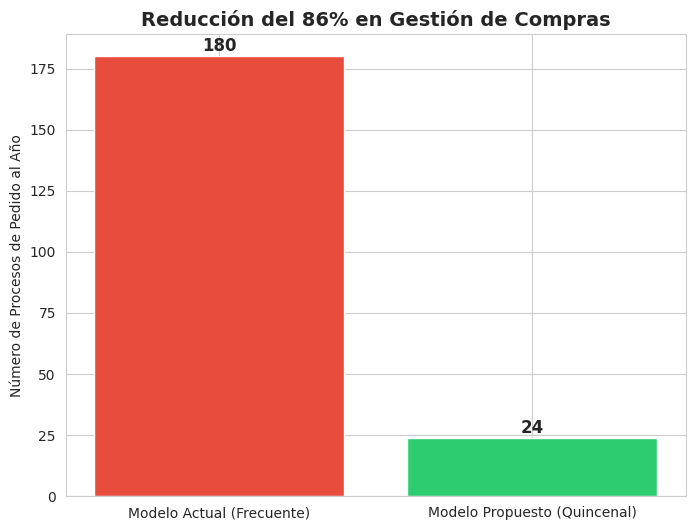

In [51]:
# BLOQUE 3: Gráfico de Carga Administrativa
labels = ['Modelo Actual (Frecuente)', 'Modelo Propuesto (Quincenal)']
pedidos = [180, 24] # Pedidos por año aproximadamente

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, pedidos, color=['#e74c3c', '#2ecc71'])

# Añadir el número encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, yval, ha='center', fontsize=12, fontweight='bold')

plt.title('Reducción del 86% en Gestión de Compras', fontsize=14, fontweight='bold')
plt.ylabel('Número de Procesos de Pedido al Año')
plt.show()

**EDA - ANALISIS DE ESTACIONALIDAD MENSUAL**

/tmp/ipython-input-2555407688.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




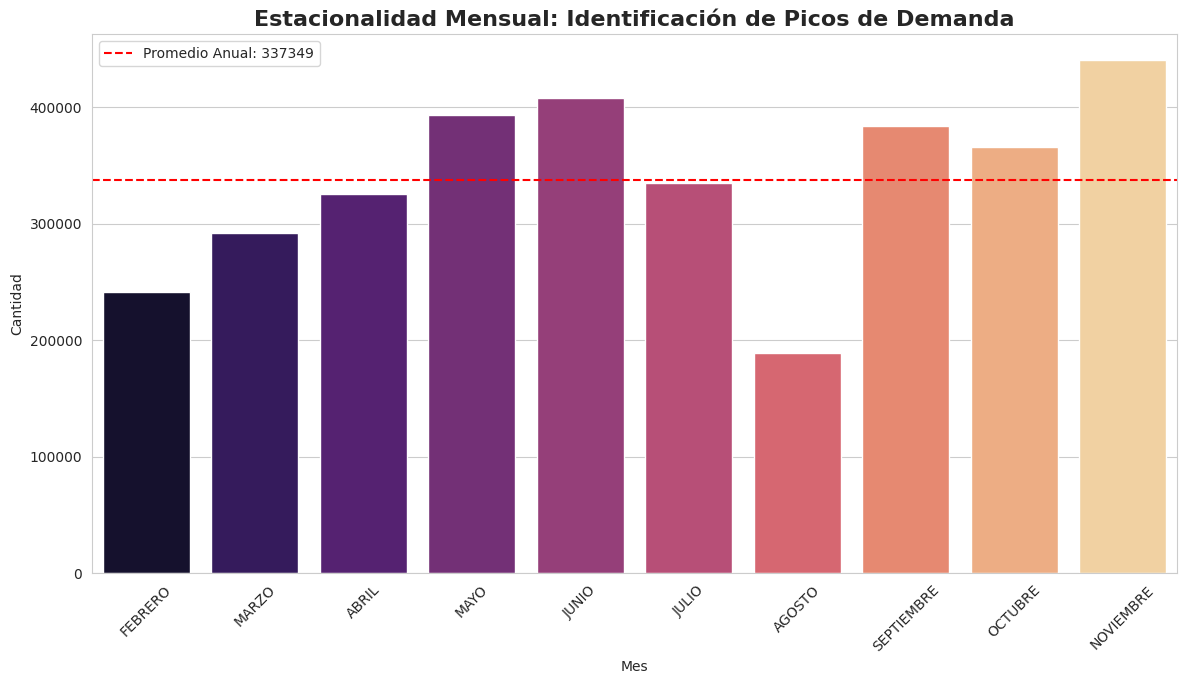

In [52]:
# Preparamos los datos
estacionalidad_grafico = df_final.groupby(['Month_Num', 'Mes'])['Cantidad'].sum().reset_index()

plt.figure(figsize=(14, 7))
# Usamos la paleta 'Spectral' o 'coolwarm' para que sea muy visual
sns.barplot(data=estacionalidad_grafico, x='Mes', y='Cantidad', palette='magma')

# Añadimos una línea de promedio anual para comparar
promedio_anual = estacionalidad_grafico['Cantidad'].mean()
plt.axhline(promedio_anual, color='red', linestyle='--', label=f'Promedio Anual: {int(promedio_anual)}')

plt.title('Estacionalidad Mensual: Identificación de Picos de Demanda', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**EDA PREPARACION DE DATOS PARA LA PREDICCION**

TABLA DE PRODUCTOS QUE REPRESENTAN EL 80% DE LA DEMANDA
                                             Producto  Cantidad
0   STICKER ESCUDO COLOR ROJO DELINEADO BLANCO 3CM...  397742.0
1   12410-2000 - TOALLITA ANTISEPTICA CLORHEXIDINA...  385622.0
2            STICKER IDENTIF MEDICAM PRECOR 6.5*7 ADH  243791.0
3                      00501T - TAPABOCAS DESECHABLES  154132.0
4   16401G - GASA NO TEJIDA ESTERIL 7.5 X 7.5 SOBR...  143639.0
5                              GORRO DESECHABLE ORUGA  136443.0
6                     POLAINAS DESECHABLES RESORTADAS  102507.0
7           COMPRESA ESTERIL 45 X 45 X 4PLG MANIJ SEG   78684.0
8                   INTEGRADOR QUIMICO A VAPOR  1243A   71242.0
9   12611-2000 - TOALLITA ANTISPTICA ALCOHOL ISOPR...   67810.0
10  01838A - APOSITO FIJACION CATETER PERIFERICO A...   52429.0
11                                  STICKER PATOLOGIA   49441.0
12  STICKER ESCUDO COLOR AZUL DELINEADO BLANCO 3CM...   47450.0
13   00178T - TAPABOCA C/PRENSES Y AMARRE CJX50 

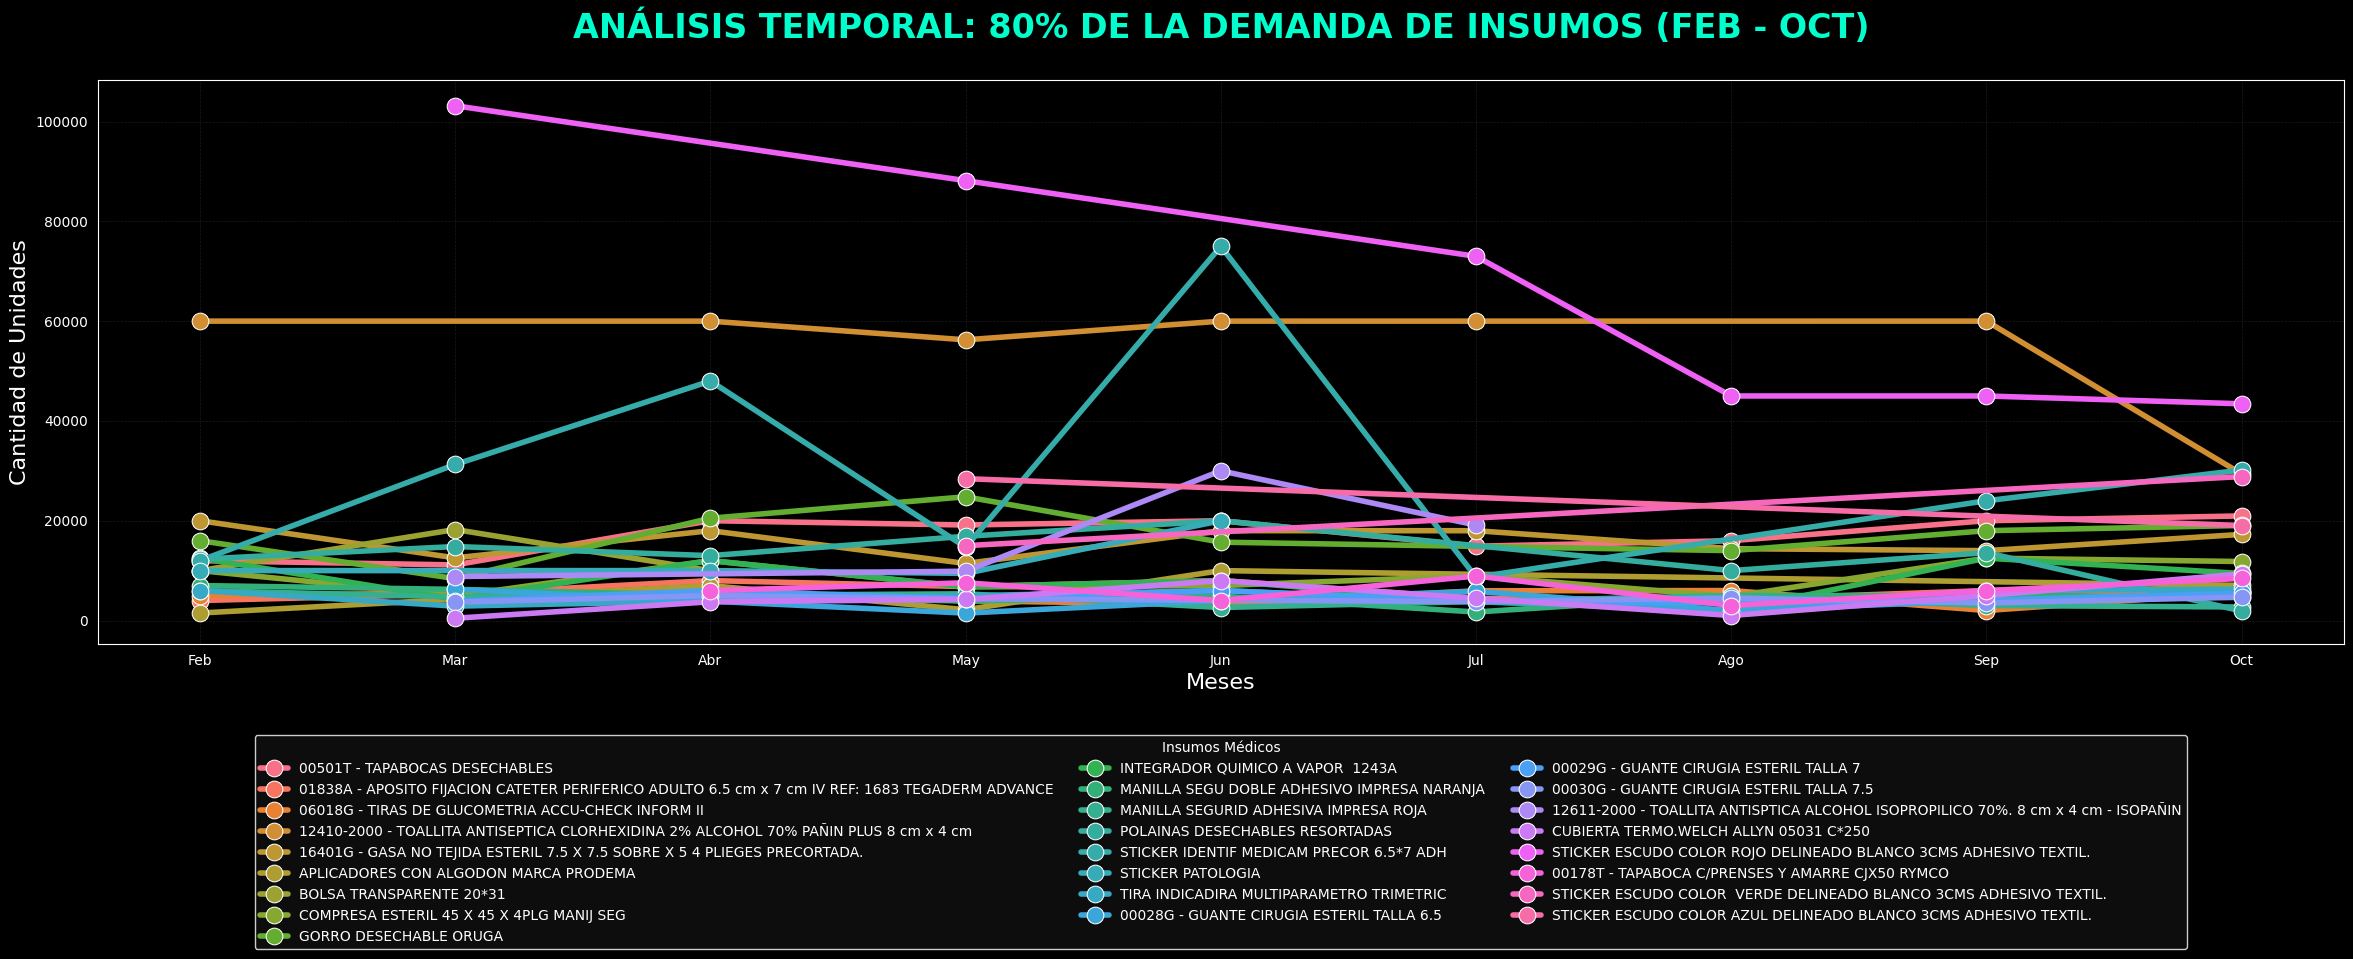

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filtrar periodo Febrero - Octubre (Meses 1 al 9)
df_periodo = df_final[(df_final['Month_Num'] >= 1) & (df_final['Month_Num'] <= 9)].copy()

# 2. Identificar el 80% de la demanda (Pareto)
demanda_prod = df_periodo.groupby('Producto')['Cantidad'].sum().sort_values(ascending=False).reset_index()
demanda_prod['Pareto'] = demanda_prod['Cantidad'].cumsum() / demanda_prod['Cantidad'].sum()
productos_80 = demanda_prod[demanda_prod['Pareto'] <= 0.805]['Producto'].tolist()

# 3. Preparar datos para las líneas
df_lineas = df_periodo[df_periodo['Producto'].isin(productos_80)]
df_lineas = df_lineas.groupby(['Month_Num', 'Producto'])['Cantidad'].sum().reset_index()

# Mapeo de meses para el eje X
meses_nombres = {1:'Feb', 2:'Mar', 3:'Abr', 4:'May', 5:'Jun', 6:'Jul', 7:'Ago', 8:'Sep', 9:'Oct'}
df_lineas['Mes'] = df_lineas['Month_Num'].map(meses_nombres)

# --- TABLA DE DATOS SOLICITADA ---
print("TABLA DE PRODUCTOS QUE REPRESENTAN EL 80% DE LA DEMANDA")
tabla_80 = demanda_prod[demanda_prod['Producto'].isin(productos_80)][['Producto', 'Cantidad']].reset_index(drop=True)
print(tabla_80)

# --- CONFIGURACIÓN DEL GRÁFICO ---
plt.style.use('dark_background')
plt.figure(figsize=(24, 10)) # Ultra ancho para evitar amontonamiento

# Paleta de colores variada para que no se repitan
palette = sns.color_palette("husl", len(productos_80))

# Dibujar las líneas sin etiquetas laterales
sns.lineplot(data=df_lineas, x='Mes', y='Cantidad', hue='Producto',
             marker='o', markersize=12, linewidth=4, palette=palette)

# Personalización de títulos y etiquetas
plt.title('ANÁLISIS TEMPORAL: 80% DE LA DEMANDA DE INSUMOS (FEB - OCT)',
          fontsize=24, color='#00FFCC', pad=30, fontweight='bold')
plt.xlabel('Meses', fontsize=16, color='white')
plt.ylabel('Cantidad de Unidades', fontsize=16, color='white')

# Cuadrícula sutil
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.2)

# LEYENDA SOLO ABAJO (Organizada en columnas para que se entienda mejor)
plt.legend(title='Insumos Médicos', bbox_to_anchor=(0.5, -0.15), loc='upper center',
           ncol=3, fontsize=10, frameon=True, facecolor='#111111', edgecolor='white')

plt.tight_layout()
plt.show()

# Reset del estilo
plt.style.use('default')


TABLA 1: MÉTRICAS GLOBALES DEL MODELO (80% DEMANDA)
R2 Score: 0.6609
MAE: 4886.55 unidades
RMSE: 8128.99 unidades

TABLA 2: DETALLE POR PRODUCTO Y PRECISIÓN
                      Producto  Real_Noviembre  Prediccion Precision_Individual Modelo_Usado
STICKER ESCUDO COLOR ROJO DELI         30000.0     28464.0               94.88%    Regresion
12410-2000 - TOALLITA ANTISEPT         32000.0     31352.0               97.97%      XGBoost
STICKER IDENTIF MEDICAM PRECOR         30000.0     30294.0               99.02%      XGBoost
00501T - TAPABOCAS DESECHABLES         24000.0     20785.0               86.60%    Regresion
16401G - GASA NO TEJIDA ESTERI          1800.0     14114.0                0.00%      XGBoost
        GORRO DESECHABLE ORUGA         14000.0     18223.0               69.84% RandomForest
POLAINAS DESECHABLES RESORTADA         17900.0      6683.0               37.34% RandomForest
12611-2000 - TOALLITA ANTISPTI         15000.0     19159.0               72.28%      XGBoost
01838

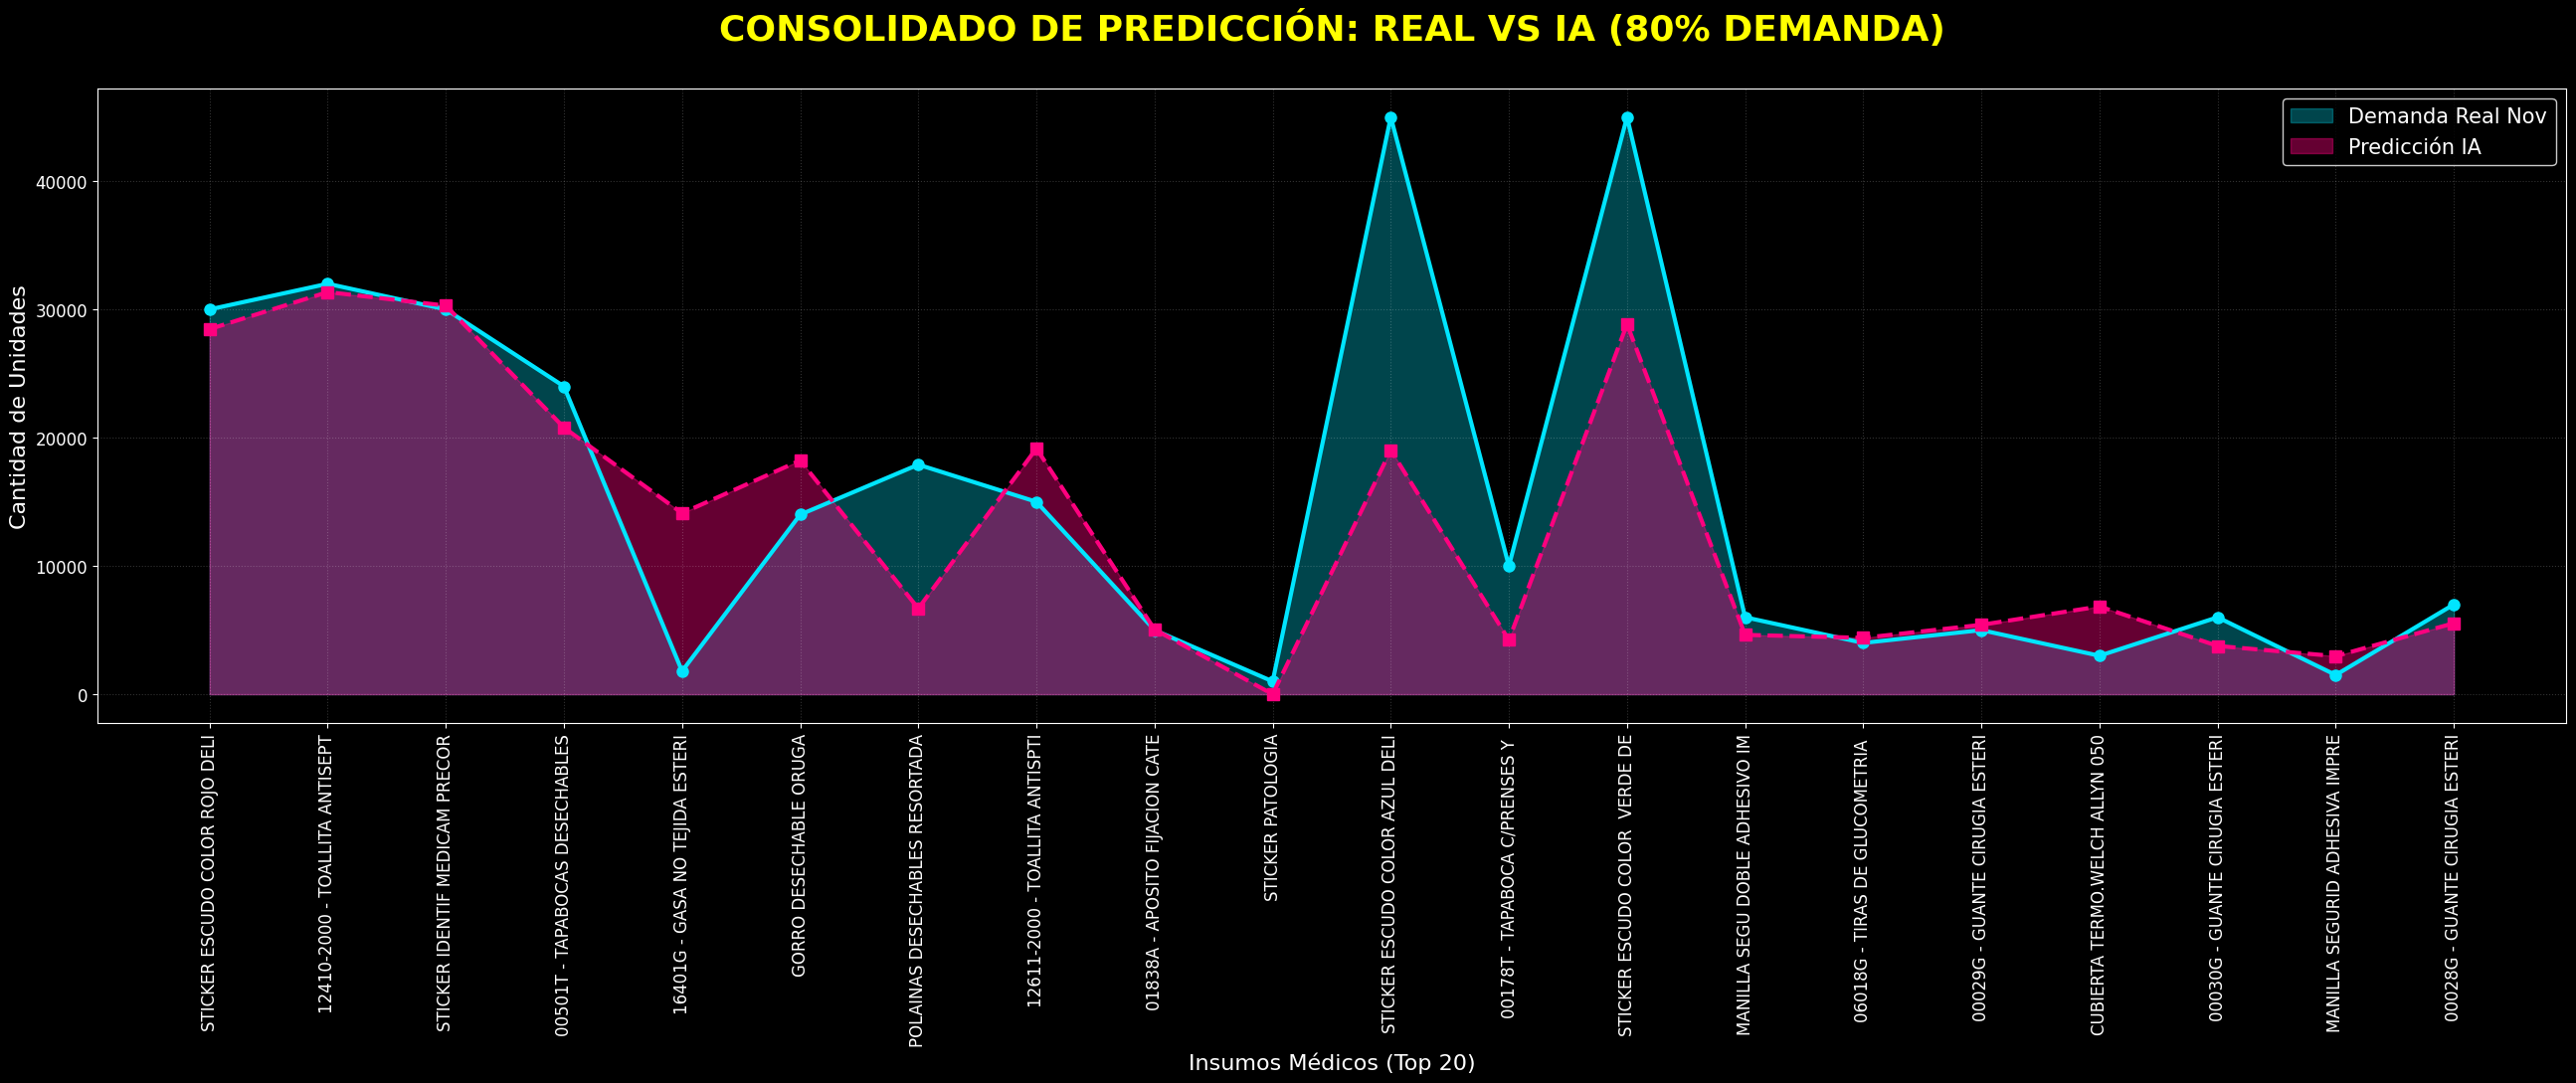

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. IDENTIFICACIÓN ESTRICTA DEL 80% DE LA DEMANDA (Top 25)
df_periodo = df_final[(df_final['Month_Num'] >= 1) & (df_final['Month_Num'] <= 9)].copy()
demanda_total = df_periodo.groupby('Producto')['Cantidad'].sum().sort_values(ascending=False).reset_index()
demanda_total['Porc_Acum'] = demanda_total['Cantidad'].cumsum() / demanda_total['Cantidad'].sum()

top_25_productos = demanda_total.head(25)['Producto'].tolist()
df_m = df_final[df_final['Producto'].isin(top_25_productos)].groupby(['Producto', 'Producto_ID', 'Month_Num']).agg({'Cantidad': 'sum'}).reset_index()

# 2. INGENIERÍA DE CARACTERÍSTICAS
df_m = df_m.sort_values(['Producto_ID', 'Month_Num'])
df_m['Lag_1'] = df_m.groupby('Producto_ID')['Cantidad'].shift(1)
df_m = df_m.dropna()

# 3. COMPETENCIA PRODUCTO POR PRODUCTO
modelos_candidatos = {
    "Regresion": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
}

predicciones_noviembre = []

for prod in top_25_productos:
    data_p = df_m[df_m['Producto'] == prod]
    train = data_p[data_p['Month_Num'] <= 9]
    test = data_p[data_p['Month_Num'] == 10]

    if test.empty or train.empty:
        continue

    X_train, y_train = train[['Month_Num', 'Lag_1']], train['Cantidad']
    X_test, y_test = test[['Month_Num', 'Lag_1']], test['Cantidad']

    mejor_prec_prod = -np.inf
    mejor_modelo_p = ""
    mejor_pred_p = 0

    for nombre, mod in modelos_candidatos.items():
        try:
            mod.fit(X_train, y_train)
            p = max(0, mod.predict(X_test)[0])
            actual_val = y_test.values[0]
            error = abs(actual_val - p)
            precision_local = 1 - (error / (actual_val + 1))

            if precision_local > mejor_prec_prod:
                mejor_prec_prod = precision_local
                mejor_modelo_p = nombre
                mejor_pred_p = p
        except:
            continue

    if mejor_modelo_p:
        predicciones_noviembre.append({
            'Producto': prod[:30], # Nombre corto para el gráfico
            'Real_Noviembre': y_test.values[0],
            'Prediccion': round(mejor_pred_p, 0),
            'Modelo_Usado': mejor_modelo_p,
            'Precision_Individual': f"{max(0, mejor_prec_prod)*100:.2f}%"
        })

# 4. GENERACIÓN DE TABLAS Y GRÁFICO
if not predicciones_noviembre:
    print("No se generaron predicciones.")
else:
    df_res = pd.DataFrame(predicciones_noviembre)

    # --- TABLA 1: MÉTRICAS GLOBALES ---
    y_true = df_res['Real_Noviembre']
    y_pred = df_res['Prediccion']

    print("\n" + "="*60)
    print("TABLA 1: MÉTRICAS GLOBALES DEL MODELO (80% DEMANDA)")
    print(f"R2 Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f} unidades")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f} unidades")
    print("="*60)

    # --- TABLA 2: COMPARACIÓN DETALLADA ---
    print("\nTABLA 2: DETALLE POR PRODUCTO Y PRECISIÓN")
    pd.set_option('display.max_rows', None)
    print(df_res[['Producto', 'Real_Noviembre', 'Prediccion', 'Precision_Individual', 'Modelo_Usado']].to_string(index=False))

    # --- GRÁFICO DE ÁREAS 'BIEN CHÉVERE' (FONDO NEGRO) ---
    plt.style.use('dark_background')
    plt.figure(figsize=(26, 11))

    x = np.arange(len(df_res))

    # Área para lo Real (Cian Neón)
    plt.fill_between(x, df_res['Real_Noviembre'], color="#00E5FF", alpha=0.3, label='Demanda Real Nov')
    plt.plot(x, df_res['Real_Noviembre'], color="#00E5FF", marker='o', linewidth=3, markersize=8)

    # Área para la Predicción (Rosa Neón)
    plt.fill_between(x, df_res['Prediccion'], color="#FF007F", alpha=0.4, label='Predicción IA')
    plt.plot(x, df_res['Prediccion'], color="#FF007F", linestyle='--', marker='s', linewidth=3, markersize=8)

    # Estética del gráfico
    plt.title('CONSOLIDADO DE PREDICCIÓN: REAL VS IA (80% DEMANDA)', fontsize=26, color='yellow', pad=35, fontweight='bold')
    plt.xticks(x, df_res['Producto'], rotation=90, fontsize=12, color='white')
    plt.yticks(fontsize=12, color='white')
    plt.xlabel('Insumos Médicos (Top 20)', fontsize=16, color='white')
    plt.ylabel('Cantidad de Unidades', fontsize=16, color='white')
    plt.grid(True, linestyle=':', alpha=0.2)
    plt.legend(fontsize=15, loc='upper right', frameon=True, facecolor='black', edgecolor='white')

    plt.tight_layout()
    plt.show()
    plt.style.use('default')

In [55]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. PREPARACIÓN DE DATOS (Cálculo de pesos y grupos)
total_unidades_80 = df_res['Real_Noviembre'].sum()
df_res['Peso_Demanda_%'] = round((df_res['Real_Noviembre'] / total_unidades_80) * 100, 2)
df_res['Precision_Num'] = df_res['Precision_Individual'].str.replace('%', '').astype(float)

# Separar los DataFrames
df_alta = df_res[df_res['Precision_Num'] >= 70].copy().sort_values('Precision_Num', ascending=False)
df_baja = df_res[df_res['Precision_Num'] < 70].copy().sort_values('Precision_Num', ascending=False)

# 2. CREACIÓN DEL GRÁFICO INTERACTIVO CON BOTONES
fig = go.Figure()

# --- TRAZA 1: ALTA PRECISIÓN (Visible por defecto) ---
fig.add_trace(
    go.Bar(
        x=df_alta['Producto'],
        y=df_alta['Precision_Num'],
        name='Alta Precisión',
        visible=True,
        marker=dict(color='#00FFCC', line=dict(color='white', width=1)),
        customdata=np.stack((df_alta['Peso_Demanda_%'], df_alta['Modelo_Usado']), axis=-1),
        hovertemplate="<b>%{x}</b><br>" +
                      "Precisión: %{y}%<br>" +
                      "Peso en la Demanda: %{customdata[0]}%<br>" +
                      "Modelo: %{customdata[1]}<extra></extra>"
    )
)

# --- TRAZA 2: BAJA PRECISIÓN (Oculta por defecto) ---
fig.add_trace(
    go.Bar(
        x=df_baja['Producto'],
        y=df_baja['Precision_Num'],
        name='Baja Precisión',
        visible=False,
        marker=dict(color='#FF3131', line=dict(color='white', width=1)),
        customdata=np.stack((df_baja['Peso_Demanda_%'], df_baja['Modelo_Usado']), axis=-1),
        hovertemplate="<b>%{x}</b><br>" +
                      "Precisión: %{y}%<br>" +
                      "Peso en la Demanda: %{customdata[0]}%<br>" +
                      "Modelo: %{customdata[1]}<extra></extra>"
    )
)

# 3. CONFIGURACIÓN DE BOTONES (MENÚ DE ACTUALIZACIÓN)
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.5,
            y=1.15,
            xanchor="center",
            buttons=list([
                dict(
                    label="Alta Precisión (≥70%)",
                    method="update",
                    args=[{"visible": [True, False]},
                          {"title": f"Productos de Alta Fiabilidad (Pesos en Demanda: {df_alta['Peso_Demanda_%'].sum():.1f}%)"}]
                ),
                dict(
                    label="Baja Precisión (<70%)",
                    method="update",
                    args=[{"visible": [False, True]},
                          {"title": f"Productos por Mejorar (Pesos en Demanda: {df_baja['Peso_Demanda_%'].sum():.1f}%)"}]
                ),
            ]),
            font=dict(color="black", size=14),
            bgcolor="white"
        )
    ],
    template="plotly_dark",
    title_text=f"ANÁLISIS DE PREDICCIÓN: ALTA PRECISIÓN (Pesos en Demanda: {df_alta['Peso_Demanda_%'].sum():.1f}%)",
    title_x=0.5,
    xaxis=dict(title="Insumos Médicos", tickangle=45),
    yaxis=dict(title="Precisión %", range=[0, 105]),
    height=700,
    width=1200,
    margin=dict(t=150)
)

# Mostrar el Dashboard
fig.show()

# --- TABLA DE APOYO PARA TU DOCUMENTO ---
print(f"\nRESUMEN DE COBERTURA:")
print(f"El grupo de ALTA PRECISIÓN cubre el {df_alta['Peso_Demanda_%'].sum():.1f}% de la demanda del hospital.")
print(f"El grupo de BAJA PRECISIÓN cubre el {df_baja['Peso_Demanda_%'].sum():.1f}% de la demanda del hospital.")


RESUMEN DE COBERTURA:
El grupo de ALTA PRECISIÓN cubre el 52.1% de la demanda del hospital.
El grupo de BAJA PRECISIÓN cubre el 47.9% de la demanda del hospital.


In [56]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. LIMPIEZA DE NOMBRES EN AMBOS DATAFRAMES
# Eliminamos puntos suspensivos y espacios extras que causan los ceros
df_final['Producto'] = df_final['Producto'].astype(str).str.strip()
df_res['Producto_Limpio'] = df_res['Producto'].astype(str).str.replace('...', '', regex=False).str.strip()

# 2. IDENTIFICAR LOS 10 PRODUCTOS CON MENOR PRECISIÓN
df_res['Precision_Num'] = df_res['Precision_Individual'].str.replace('%', '').astype(float)
df_peores_10 = df_res.sort_values('Precision_Num', ascending=True).head(10).copy()

# 3. EXTRAER HISTORIAL USANDO COINCIDENCIA PARCIAL
# Esto asegura que encuentre el nombre completo original en df_final
nombres_cortados = df_peores_10['Producto_Limpio'].tolist()
nombres_reales = []

for nc in nombres_cortados:
    # Buscamos en df_final el nombre que contenga esa parte inicial
    match = df_final[df_final['Producto'].str.contains(nc, case=False, na=False)]['Producto'].unique()
    if len(match) > 0:
        nombres_reales.append(match[0])

# 4. CONSTRUCCIÓN DE LA TABLA MENSUAL (FEB - NOV)
df_hist_real = df_final[df_final['Producto'].isin(nombres_reales)].copy()
resumen_mensual = df_hist_real.groupby(['Producto', 'Month_Num'])['Cantidad'].sum().unstack(fill_value=0)

# Mapeo de meses (Aseguramos que Oct y Nov aparezcan)
meses_nombres = {1:'Feb', 2:'Mar', 3:'Abr', 4:'May', 5:'Jun', 6:'Jul', 7:'Ago', 8:'Sep', 9:'Oct', 10:'Nov'}
resumen_mensual.columns = [meses_nombres.get(c, c) for c in resumen_mensual.columns]

# 5. CÁLCULO DE VOLATILIDAD (CV)
stats_v = df_hist_real.groupby('Producto')['Cantidad'].agg(['std', 'mean'])
stats_v['CV'] = (stats_v['std'] / (stats_v['mean'] + 1)).round(2)

# 6. UNIÓN FINAL PARA LA TABLA DE TESIS
# Cruzamos por el nombre real recuperado
tabla_analisis = resumen_mensual.reset_index().merge(
    df_peores_10[['Producto', 'Prediccion', 'Precision_Individual']],
    left_on='Producto',
    right_on=df_peores_10['Producto'].apply(lambda x: next((r for r in nombres_reales if x.replace('...','').strip() in r), x))
)
tabla_analisis = tabla_analisis.merge(stats_v[['CV']], left_on='Producto_x', right_index=True)

# 7. MOSTRAR TABLA Y GRÁFICO
cols_mostrar = ['Producto_x', 'Oct', 'Nov', 'Prediccion', 'Precision_Individual', 'CV']
print("\n" + "="*110)
print("TABLA DE VOLATILIDAD: LOS 10 PRODUCTOS CRÍTICOS (VALORES REALES RECUPERADOS)")
print("="*110)
print(tabla_analisis[cols_mostrar].to_string(index=False))

# Gráfico de líneas
fig = go.Figure()
for prod in nombres_reales:
    y_values = resumen_mensual.loc[prod]
    cv_val = stats_v.loc[prod, 'CV']

    fig.add_trace(go.Scatter(
        x=list(meses_nombres.values()),
        y=y_values,
        name=f"{prod[:20]} (CV: {cv_val})",
        mode='lines+markers',
        line=dict(width=3)
    ))

fig.update_layout(title="CAUSA DE BAJA PRECISIÓN: VOLATILIDAD HISTÓRICA", template="plotly_dark", height=700)
fig.show()


TABLA DE VOLATILIDAD: LOS 10 PRODUCTOS CRÍTICOS (VALORES REALES RECUPERADOS)
                                                               Producto_x     Oct     Nov  Prediccion Precision_Individual   CV
                                00030G - GUANTE CIRUGIA ESTERIL TALLA 7.5  4673.0  6000.0      3765.0               62.76% 0.69
                         00178T - TAPABOCA C/PRENSES Y AMARRE CJX50 RYMCO  8435.0 10000.0      4232.0               42.32% 0.79
16401G - GASA NO TEJIDA ESTERIL 7.5 X 7.5 SOBRE X 5 4 PLIEGES PRECORTADA. 17260.0  1800.0     14114.0                0.00% 0.79
                                   CUBIERTA TERMO.WELCH ALLYN 05031 C*250  9342.0  3000.0      6843.0                0.00% 0.90
                                                   GORRO DESECHABLE ORUGA 19044.0 14000.0     18223.0               69.84% 0.79
                                    MANILLA SEGURID ADHESIVA IMPRESA ROJA  2707.0  1500.0      2969.0                2.12% 0.76
                          

In [57]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. LIMPIEZA INICIAL DE NOMBRES
df_final['Producto'] = df_final['Producto'].astype(str).str.strip()
df_res['Producto'] = df_res['Producto'].astype(str).str.strip()

# 2. CÁLCULO DE CV SOBRE LA DATA ORIGINAL (df_final)
# Esto garantiza que el CV sea real y basado en toda la historia (Feb-Nov)
stats_hist = df_final.groupby('Producto')['Cantidad'].agg(['std', 'mean']).reset_index()
stats_hist['CV'] = (stats_hist['std'] / (stats_hist['mean'] + 0.1)).round(2)

# 3. IDENTIFICAR LOS PRODUCTOS DE BAJA PRECISIÓN
df_res['Precision_Num'] = df_res['Precision_Individual'].str.replace('%', '').astype(float)
df_baja = df_res[df_res['Precision_Num'] < 70].copy()

# 4. CRUZAR AMBAS TABLAS PARA OBTENER EL CV DE LOS QUE FALLARON
# Usamos una búsqueda de coincidencia parcial para evitar el error de los nombres cortados
lista_criticos = []
for index, row in df_baja.iterrows():
    nombre_res = row['Producto'].replace('...', '').strip()
    # Buscamos el nombre completo en la historia
    match = stats_hist[stats_hist['Producto'].str.contains(nombre_res, case=False, na=False)]
    if not match.empty:
        # Añadimos los datos de precisión a la estadística
        match = match.copy()
        match['Precision_Individual'] = row['Precision_Individual']
        match['Prediccion'] = row['Prediccion']
        lista_criticos.append(match)

df_analisis_cv = pd.concat(lista_criticos)

# 5. SELECCIONAR LOS 3 CON MAYOR CV
top_3_volatiles = df_analisis_cv.sort_values('CV', ascending=False).head(3)
nombres_top_3 = top_3_volatiles['Producto'].tolist()

# 6. EXTRAER DATA MENSUAL REAL PARA EL GRÁFICO
resumen_3 = df_final[df_final['Producto'].isin(nombres_top_3)].groupby(['Producto', 'Month_Num'])['Cantidad'].sum().unstack(fill_value=0)
meses_map = {1:'Feb', 2:'Mar', 3:'Abr', 4:'May', 5:'Jun', 6:'Jul', 7:'Ago', 8:'Sep', 9:'Oct', 10:'Nov'}
resumen_3.columns = [meses_map.get(c, c) for c in resumen_3.columns]

# 7. TABLA DE RESULTADOS PARA LA TESIS
tabla_final = resumen_3.merge(top_3_volatiles[['Producto', 'Prediccion', 'Precision_Individual', 'CV']], on='Producto')

print("\n" + "="*100)
print("ANÁLISIS DE IMPACTO: LOS 3 PRODUCTOS MÁS VOLÁTILES (MÁXIMO CV)")
print("="*100)
cols_ver = ['Producto', 'Oct', 'Nov', 'Prediccion', 'Precision_Individual', 'CV']
print(tabla_final[cols_ver].to_string(index=False))

# 8. GRÁFICO DE LÍNEAS INTERACTIVO
fig = go.Figure()
for prod in nombres_top_3:
    y_values = resumen_3.loc[prod]
    cv_val = top_3_volatiles[top_3_volatiles['Producto'] == prod]['CV'].values[0]

    fig.add_trace(go.Scatter(
        x=list(meses_map.values()),
        y=y_values,
        name=f"CV: {cv_val} | {prod[:20]}",
        mode='lines+markers',
        line=dict(width=4),
        marker=dict(size=10)
    ))

fig.update_layout(
    title="DEMOSTRACIÓN DE VOLATILIDAD EXTREMA (TOP 3 CV)",
    template="plotly_dark",
    xaxis_title="Evolución Mensual",
    yaxis_title="Cantidad Consumida",
    height=600
)
fig.show()


ANÁLISIS DE IMPACTO: LOS 3 PRODUCTOS MÁS VOLÁTILES (MÁXIMO CV)
                                                        Producto     Oct     Nov  Prediccion Precision_Individual   CV
                          CUBIERTA TERMO.WELCH ALLYN 05031 C*250  9342.0  3000.0      6843.0                0.00% 0.91
STICKER ESCUDO COLOR AZUL DELINEADO BLANCO 3CMS ADHESIVO TEXTIL. 19029.0 45000.0     19029.0               42.29% 0.88
                                               STICKER PATOLOGIA     0.0  1000.0         0.0                0.10% 0.98
